<a href="https://colab.research.google.com/github/gettokeroro/DADS6003-Homeworks/blob/main/Week8_ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Classification

### Dataset: [Breast Cancer Wisconsin (Diagnostic)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

- **Samples**: 569
- **Features**: 30 (radius, texture, perimeter, area, smoothness, etc.)
- **Classes**: 2 (malignant, benign)
- **Task**: Binary classification

In [20]:
# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.datasets import load_breast_cancer

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.3
CV_FOLDS = 5
OPTUNA_N_TRIALS = 10

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)

cancer = load_breast_cancer()
print(f"Data shape: {cancer.data.shape}")
print(f"Target shape: {cancer.target.shape}")
print(f"Feature names: {cancer.feature_names}... (30 total)")
print(f"Target names: {cancer.target_names}")
print(f"Class distribution: {dict(zip(*np.unique(cancer.target, return_counts=True)))}")

Data shape: (569, 30)
Target shape: (569,)
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']... (30 total)
Target names: ['malignant' 'benign']
Class distribution: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

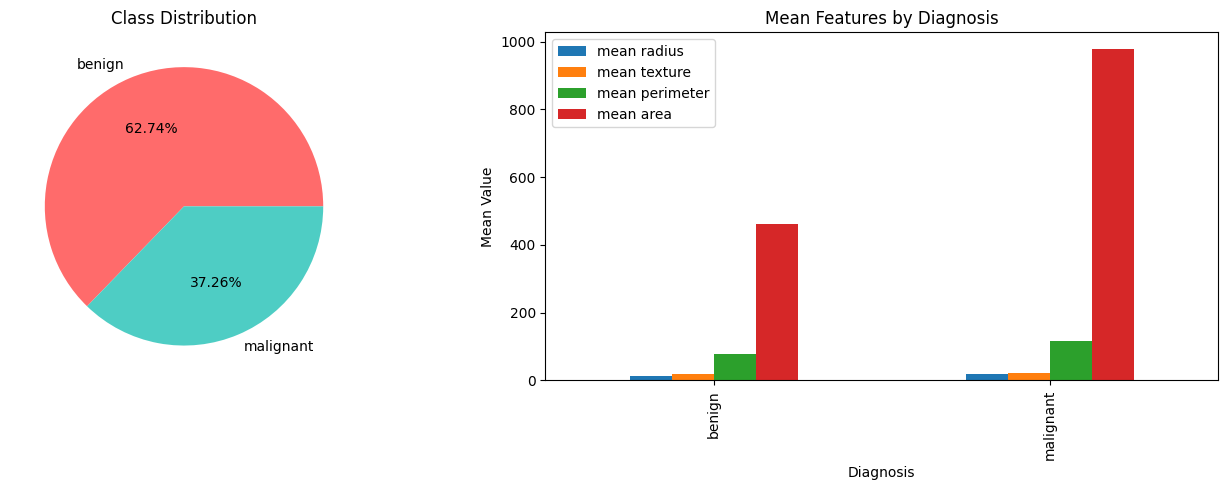

In [22]:
# Create DataFrame for EDA
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df['diagnosis'] = cancer_df['target'].map({0: 'malignant', 1: 'benign'})

# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class balance
axes[0].pie(cancer_df['diagnosis'].value_counts(),
            labels=cancer_df['diagnosis'].value_counts().index,
            autopct='%1.2f%%', colors=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Class Distribution')

# Feature statistics by class
features = cancer_df.columns.drop(['target', 'diagnosis'])
cancer_df.groupby('diagnosis')[features[0:4]].mean().plot(
    kind='bar', ax=axes[1] )#, color=['#ff6b6b', '#4ecdc4', '#336699'])
axes[1].set_title('Mean Features by Diagnosis')
axes[1].set_xlabel('Diagnosis')
axes[1].set_ylabel('Mean Value')
axes[1].legend(loc='best')
plt.tight_layout()
plt.show()

## 2. Exploratory Data Analysis (EDA)

In [23]:
print("Dataset Statistics:")
print(cancer_df.info())

print("\nMissing Values:")
print(cancer_df.isnull().sum().sum())

Dataset Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smooth

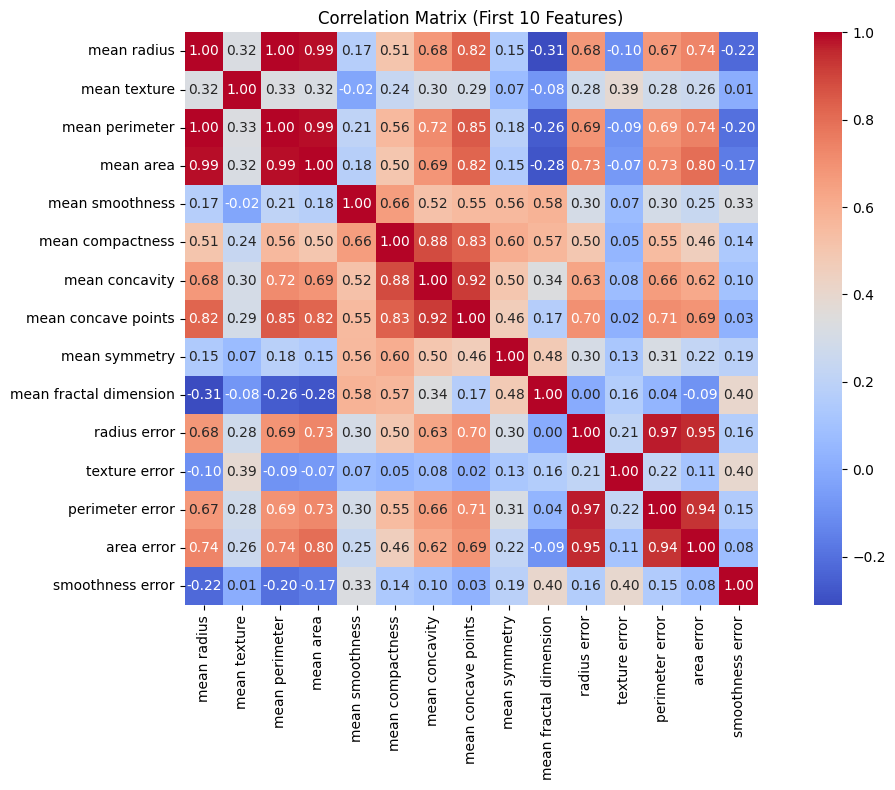


Correlations with Target (Top 10):
worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
Name: target, dtype: float64


In [24]:
import seaborn as sns

# Create correlation matrix with target included
corr_data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
corr_data['target'] = cancer.target
corr_matrix = corr_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.iloc[:15, :15], annot=True, fmt=".2f", cmap="coolwarm", square=True)
#corr_matrix.iloc[15:, 15:]
plt.title("Correlation Matrix (First 10 Features)")
plt.tight_layout()
plt.show()

print("\nCorrelations with Target (Top 10):")
corr_with_target = corr_matrix['target'].drop('target').abs().sort_values(ascending=False)[:10]
print(corr_with_target)

## 3. Feature Selection

### 3.1 Correlation-Based Feature Selection

In [25]:
# Use corr_data from previous cell or recreate it
'''if 'corr_data' not in locals():
    corr_data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
    corr_data['target'] = cancer.target
    corr_matrix = corr_data.corr()
else:
    corr_matrix = corr_data.corr()'''

correlations = corr_matrix['target'].drop('target').abs().sort_values(ascending=False)

#print("Feature Correlations with Target (Absolute Values):")
#print(correlations)

corr_threshold = 0.6
selected_features_corr = correlations[correlations > corr_threshold].index.tolist()

print(f"\nSelected features (correlation > {corr_threshold}): {len(selected_features_corr)}")
print(selected_features_corr)


Selected features (correlation > 0.6): 10
['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter', 'worst area', 'mean radius', 'mean area', 'mean concavity', 'worst concavity']


### 3.2 SelectKBest with f_classif

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

k_features = 10
selector_kbest = SelectKBest(score_func=f_classif, k=k_features)
X_kbest = selector_kbest.fit_transform(cancer.data, cancer.target)

selected_mask = selector_kbest.get_support()
selected_features_kbest = [f for f, selected in zip(cancer.feature_names, selected_mask) if selected]

print(f"Top {k_features} features selected by SelectKBest (f_classif):")
print(selected_features_kbest)

print("\nF-scores for all features (top 10):")
for feature, score in sorted(zip(cancer.feature_names, selector_kbest.scores_),
                              key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {feature}: {score:.4f}")

Top 10 features selected by SelectKBest (f_classif):
[np.str_('mean radius'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('worst radius'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst concavity'), np.str_('worst concave points')]

F-scores for all features (top 10):
  worst concave points: 964.3854
  worst perimeter: 897.9442
  mean concave points: 861.6760
  worst radius: 860.7817
  mean perimeter: 697.2353
  worst area: 661.6002
  mean radius: 646.9810
  mean area: 573.0607
  mean concavity: 533.7931
  worst concavity: 436.6919


### 3.3 SelectFromModel with L1-based Classifier

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr_fs = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)
lr_fs.fit(cancer.data, cancer.target)

selector_lr = SelectFromModel(lr_fs, prefit=True)
X_lr_selected = selector_lr.transform(cancer.data)

selected_mask_lr = selector_lr.get_support()
selected_features_lr = [f for f, selected in zip(cancer.feature_names, selected_mask_lr) if selected]

print("Features selected by Logistic Regression L1 (non-zero coefficients):")
print(selected_features_lr)
print(f"\nNumber of features selected: {len(selected_features_lr)}")

Features selected by Logistic Regression L1 (non-zero coefficients):
[np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('texture error'), np.str_('area error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst concavity')]

Number of features selected: 11


### 3.4 Feature Selection Summary

In [28]:
fs_comparison = pd.DataFrame({'Feature': list(cancer.feature_names)})
fs_comparison['Correlation'] = fs_comparison['Feature'].isin(selected_features_corr)
fs_comparison['SelectKBest'] = fs_comparison['Feature'].isin(selected_features_kbest)
fs_comparison['L1_Logistic'] = fs_comparison['Feature'].isin(selected_features_lr)

fs_comparison.set_index('Feature', inplace=True)
print("Feature Selection Comparison:")
print(fs_comparison)

print("\nNumber of features selected by each method:")
print(f"  Correlation-based: {len(selected_features_corr)}")
print(f"  SelectKBest (k={k_features}): {len(selected_features_kbest)}")
print(f"  L1 Logistic: {len(selected_features_lr)}")

best_features = fs_comparison[fs_comparison.sum(axis=1) >= 2] #Majority vote
print(best_features)

Feature Selection Comparison:
                         Correlation  SelectKBest  L1_Logistic
Feature                                                       
mean radius                     True         True         True
mean texture                   False        False         True
mean perimeter                  True         True         True
mean area                       True         True         True
mean smoothness                False        False        False
mean compactness               False        False        False
mean concavity                  True         True        False
mean concave points             True         True        False
mean symmetry                  False        False        False
mean fractal dimension         False        False        False
radius error                   False        False        False
texture error                  False        False         True
perimeter error                False        False        False
area error               

## 4. Data Preprocessing & Train-Test Split

### Holdout technique

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#best_indices = [feature_names_list.index(f) for f in best_features]
X_best = cancer_df[best_features.index.to_list()]

X_train, X_test, y_train, y_test = train_test_split(
    X_best, cancer.target,
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=cancer.target
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"\nClass distribution in y_train: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Class distribution in y_test: {dict(zip(*np.unique(y_test, return_counts=True)))}")


Shape of X_train: (398, 10)
Shape of X_test: (171, 10)
Shape of y_train: (398,)
Shape of y_test: (171,)

Class distribution in y_train: {np.int64(0): np.int64(148), np.int64(1): np.int64(250)}
Class distribution in y_test: {np.int64(0): np.int64(64), np.int64(1): np.int64(107)}


## 5. Pipeline and Hyperparameter Tuning

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score, accuracy_score, f1_score

## 1. GridSearchCV method

In [31]:
# Define pipelines for both classifiers
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=2000))
    ]),
    'GaussianNB': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GaussianNB())
    ])
}

# Parameter grids for each classifier
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    'GaussianNB': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    }
}

results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print('='*60)

    grid_search = GridSearchCV(pipeline, param_grids[name], scoring='matthews_corrcoef',
                               cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE), n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters found by GridSearchCV for {name}:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    results[name] = {'accuracy': acc, 'f1': f1, 'mcc': mcc}

#print(results)
    #print(f"\nTest Accuracy: {acc:.4f}")
    #print(f"Test F1 Score: {f1:.4f}")

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: Model Comparison")
print("="*60)
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['accuracy']:.4f}, F1 = {metrics['f1']:.4f}, MCC = {metrics['mcc']:.4f}")


Training LogisticRegression
Best parameters found by GridSearchCV for LogisticRegression:
{'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Training GaussianNB
Best parameters found by GridSearchCV for GaussianNB:
{'classifier__var_smoothing': 1e-09}

SUMMARY: Model Comparison
LogisticRegression: Accuracy = 0.9591, F1 = 0.9680, MCC = 0.9130
GaussianNB: Accuracy = 0.9298, F1 = 0.9439, MCC = 0.8502


## 2. RandomizedSearchCV

In [32]:
from scipy.stats import loguniform
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

# Use the pipeline defined above

# Parameter distributions for each classifier
param_distributions = {
    'LogisticRegression': {
        'classifier__C': loguniform(0.01, 100),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    'GaussianNB': {
        'classifier__var_smoothing': loguniform(1e-9, 1e-5)
    }
}

results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f"Training {name} with RandomizedSearchCV")
    print('='*60)

    random_search = RandomizedSearchCV(pipeline, param_distributions[name], n_iter=100,
                                       scoring='matthews_corrcoef', cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
                                       n_jobs=-1, random_state=RANDOM_STATE)
    random_search.fit(X_train, y_train)

    print(f"Best parameters found by RandomizedSearchCV for {name}:")
    print(random_search.best_params_)

    best_random_model = random_search.best_estimator_
    y_pred_random = best_random_model.predict(X_test)

    acc_random = accuracy_score(y_test, y_pred_random)
    f1_random = f1_score(y_test, y_pred_random)
    mcc_random = matthews_corrcoef(y_test, y_pred_random)

    results[name] = {'accuracy': acc_random, 'f1': f1_random, 'mcc': mcc_random}

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: Model Comparison (RandomizedSearchCV)")
print("="*60)
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['accuracy']:.4f}, F1 = {metrics['f1']:.4f}, MCC = {metrics['mcc']:.4f}")


Training LogisticRegression with RandomizedSearchCV
Best parameters found by RandomizedSearchCV for LogisticRegression:
{'classifier__C': np.float64(7.707580772445939), 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Training GaussianNB with RandomizedSearchCV
Best parameters found by RandomizedSearchCV for GaussianNB:
{'classifier__var_smoothing': np.float64(3.148911647956859e-08)}

SUMMARY: Model Comparison (RandomizedSearchCV)
LogisticRegression: Accuracy = 0.9591, F1 = 0.9680, MCC = 0.9130
GaussianNB: Accuracy = 0.9298, F1 = 0.9439, MCC = 0.8502


### Optuna

In [33]:
!pip install optuna -qqq

In [34]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, matthews_corrcoef, average_precision_score

# Define stratified CV for reproducibility
cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier",
        ["LogisticRegression", "GaussianNB"])
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if classifier_name == "LogisticRegression":
      C = trial.suggest_float("lr_C", 0.01, 100, log=True)
      penalty = trial.suggest_categorical("lr_penalty", ["l1", "l2"])
      solver = trial.suggest_categorical("lr_solver", ['liblinear', 'saga'])
      pipe.set_params(classifier=LogisticRegression(
          C=C,
          penalty=penalty,
          solver=solver,
          random_state=RANDOM_STATE,
          max_iter=1000,
          class_weight='balanced'))  #Handle imbalanced data

    elif classifier_name == "GaussianNB":
      var_smoothing = trial.suggest_float("nb_var_smoothing", 1e-9, 1e-5, log=True)
      pipe.set_params(classifier=GaussianNB(var_smoothing=var_smoothing))

    score = cross_val_score(pipe, X_train, y_train, cv=cv_splitter,  #Stratified CV
                          scoring='matthews_corrcoef', n_jobs=-1)

    return score.mean()

In [35]:
#Set seed properly with TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))

study.optimize(objective, n_trials=OPTUNA_N_TRIALS)

if study.best_trial is not None:

    print("Best parameters found by Optuna:")
    print(study.best_params)

    print(f"Best value: {study.best_value:.4f}")

    best_params = study.best_params
    best_classifier_name = best_params["classifier"]

    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if best_classifier_name == "LogisticRegression":
        best_C = best_params["lr_C"]
        best_penalty = best_params["lr_penalty"]
        best_solver = best_params["lr_solver"]
        best_pipeline.set_params(classifier=LogisticRegression(
            C=best_C, penalty=best_penalty, solver=best_solver,
            random_state=RANDOM_STATE, max_iter=1000,
            class_weight='balanced'))
    elif best_classifier_name == "GaussianNB":
        best_var_smoothing = best_params["nb_var_smoothing"]
        best_pipeline.set_params(classifier=GaussianNB(
            var_smoothing=best_var_smoothing))

    best_pipeline.fit(X_train, y_train)
    y_pred_optuna = best_pipeline.predict(X_test)

    roc_auc_optuna = roc_auc_score(y_test, y_pred_optuna)
    mcc_optuna = matthews_corrcoef(y_test, y_pred_optuna)
    f1_optuna = f1_score(y_test, y_pred_optuna)

    print(f"\nTest ROC-AUC: {roc_auc_optuna:.4f}")
    print(f"Test MCC: {mcc_optuna:.4f}")
    print(f"Test F1: {f1_optuna:.4f}")
else:
    print("Optuna did not complete any trials successfully.")

print("\n--- Optuna Study Results ---")
print(f"Number of completed trials: {len(study.trials)}")
print(f"Best value: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

print("\n--- All Trials ---")
df = study.trials_dataframe()
print(df[["value", "params_classifier"]].to_string())

[I 2026-02-28 03:25:38,018] A new study created in memory with name: no-name-34746c2d-2283-45d9-b123-64862ace6b99
[I 2026-02-28 03:25:38,115] Trial 0 finished with value: 0.8888471336687627 and parameters: {'classifier': 'GaussianNB', 'nb_var_smoothing': 8.471801418819974e-07}. Best is trial 0 with value: 0.8888471336687627.
[I 2026-02-28 03:25:38,230] Trial 1 finished with value: 0.8842621654167792 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.042070539502879395, 'lr_penalty': 'l2', 'lr_solver': 'saga'}. Best is trial 0 with value: 0.8888471336687627.
[I 2026-02-28 03:25:38,321] Trial 2 finished with value: 0.8888471336687627 and parameters: {'classifier': 'GaussianNB', 'nb_var_smoothing': 2.1368329072358738e-06}. Best is trial 0 with value: 0.8888471336687627.
[I 2026-02-28 03:25:38,434] Trial 3 finished with value: 0.874014476184302 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.05415244119402541, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}. Best i

Best parameters found by Optuna:
{'classifier': 'LogisticRegression', 'lr_C': 4.467752817973908, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}
Best value: 0.9120

Test ROC-AUC: 0.9251
Test MCC: 0.8502
Test F1: 0.9439

--- Optuna Study Results ---
Number of completed trials: 10
Best value: 0.9120
Best params: {'classifier': 'LogisticRegression', 'lr_C': 4.467752817973908, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}

--- All Trials ---
      value   params_classifier
0  0.888847          GaussianNB
1  0.884262  LogisticRegression
2  0.888847          GaussianNB
3  0.874014  LogisticRegression
4  0.884842  LogisticRegression
5  0.888847          GaussianNB
6  0.873628  LogisticRegression
7  0.888847          GaussianNB
8  0.888847          GaussianNB
9  0.911975  LogisticRegression


In Optuna, the objective value is the performance metric returned by the objective function for a given set of hyperparameters in a single trial. This value is what Optuna aims to either maximize (e.g., accuracy, F1-score) or minimize (e.g., loss, mean squared error) during the optimization process.

In [36]:
try:
    from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice
    fig1 = plot_optimization_history(study)
    fig1.show()
except ImportError:
    print("Install optuna visualization with: pip install optuna-integration")

## 6. SHAP Analysis - Model Interpretability

In [37]:
!pip install shap -qqq

  0%|          | 0/100 [00:00<?, ?it/s]

X_test shape: (100, 10)
SHAP values shape: (100, 10)
Number of features: 30

SHAP Summary Plot:


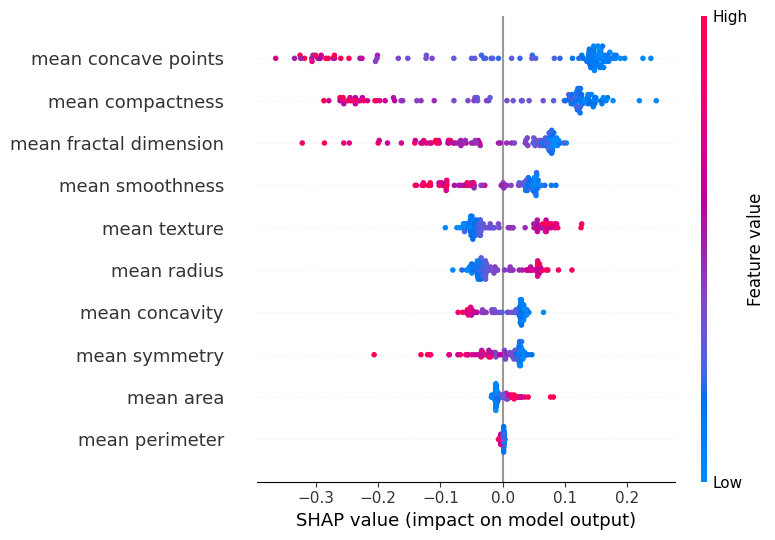


SHAP Feature Importance (Bar Plot):


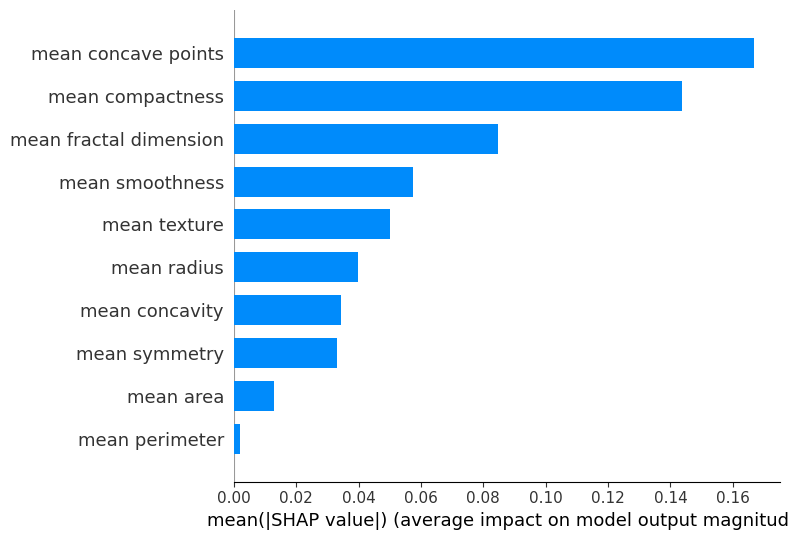


SHAP Dependence Plot for Most Important Feature:


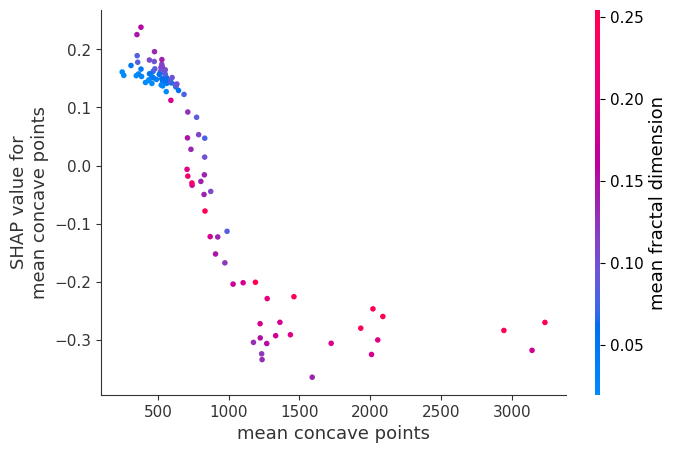

In [38]:
import shap

if study.best_trial is not None:
    best_params = study.best_params
    best_classifier_name = best_params["classifier"]

    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if best_classifier_name == "LogisticRegression":
        best_C = best_params["lr_C"]
        best_penalty = best_params["lr_penalty"]
        best_pipeline.set_params(classifier=LogisticRegression(
            C=best_C, penalty=best_penalty, solver='liblinear',
            random_state=RANDOM_STATE, max_iter=1000))
    elif best_classifier_name == "GaussianNB":
        best_var_smoothing = best_params["nb_var_smoothing"]
        best_pipeline.set_params(classifier=GaussianNB(
            var_smoothing=best_var_smoothing))

    best_pipeline.fit(X_train, y_train)

    # For SHAP, we need to use the model's predict_proba
    # Create a wrapper function
    def model_predict(X):
        return best_pipeline.predict_proba(X)[:, 1]  # Probability of positive class

    # Use KernelExplainer which works with any function
    explainer = shap.KernelExplainer(model_predict, X_train)

    # Compute SHAP values (use a subset for speed)
    np.random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    X_sample = X_train.iloc[np.random.choice(len(X_train), 100, replace=False)]
    shap_values = explainer.shap_values(X_sample)

    # Print shape information for debugging
    print(f"X_test shape: {X_sample.shape}")
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Number of features: {len(cancer.feature_names)}")

    # SHAP Summary Plot
    print("\nSHAP Summary Plot:")
    shap.summary_plot(shap_values, X_sample, feature_names=cancer.feature_names, show=False)
    plt.show()

    # SHAP Bar Plot
    print("\nSHAP Feature Importance (Bar Plot):")
    shap.summary_plot(shap_values, X_sample, feature_names=cancer.feature_names,
                      plot_type="bar", show=False)
    plt.show()

    # SHAP Dependence Plot
    print("\nSHAP Dependence Plot for Most Important Feature:")
    shap_values_arr = np.array(shap_values)
    most_important_idx = np.argmax(np.abs(shap_values_arr).mean(axis=0))
    shap.dependence_plot(most_important_idx, shap_values_arr, X_sample,
                        feature_names=cancer.feature_names, show=False)
    plt.show()
else:
    print("No trained model available for SHAP analysis. Run the Optuna optimization first.")

### Key Insights from SHAP Analysis:
1. **Feature Importance**: Features at the top have the greatest impact on predictions.
2. **Positive/Negative Impact**: Red = high values increase prediction, blue = decrease.
3. **For Classification**: SHAP shows impact on probability of each class.

### Hint
1. You should choose RandomizedSearch over GridSearch for many hyperparameters.
2. For imbalanced datasets, use stratified CV and appropriate metrics (F1, ROC-AUC).
3. SHAP values help explain which features drive classification decisions.

#Exercise: Loan classification

#### Given the dataset below, apply the technique you learned above to create classification models, and then explain the features that impact the ML results

https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/refs/heads/master/Week08-workshop-2/loan_data.csv


In [39]:
import pandas as pd

# Load the dataset
loan_data_url = "https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/refs/heads/master/Week08-workshop-2/loan_data.csv"
loan_df = pd.read_csv(loan_data_url)

print("### Dataset Head (First 5 rows):\n")
print(loan_df.head())

print("\n### Dataset Information:\n")
loan_df.info()

print("\n### Descriptive Statistics:\n")
print(loan_df.describe())

print("\n### Missing Values:\n")
print(loan_df.isnull().sum())

### Dataset Head (First 5 rows):

   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49          

In [40]:
# Identify categorical columns
categorical_cols = loan_df.select_dtypes(include=['object']).columns
print(f"Categorical columns identified: {list(categorical_cols)}")

# Apply one-hot encoding
loan_df_encoded = pd.get_dummies(loan_df, columns=categorical_cols, drop_first=True)

print("\nShape of DataFrame after one-hot encoding:")
print(loan_df_encoded.shape)

print("\nFirst 5 rows of the encoded DataFrame:")
display(loan_df_encoded.head())

Categorical columns identified: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

Shape of DataFrame after one-hot encoding:
(45000, 23)

First 5 rows of the encoded DataFrame:


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,False,...,True,False,False,True,False,False,False,True,False,False
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,False,...,False,False,True,False,True,False,False,False,False,True
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,False,...,False,False,False,False,False,False,True,False,False,False
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,False,...,False,False,False,True,False,False,True,False,False,False
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,1,True,...,True,False,False,True,False,False,True,False,False,False


## Correlation-Based Feature Selection for Loan Data

### Subtask:
Calculate the absolute correlation between each feature and the 'loan_status' target, then select features above a predefined threshold.


**Reasoning**:
To perform correlation-based feature selection, I will calculate the correlation matrix of the encoded loan DataFrame, extract the absolute correlations with the 'loan_status' target, and then filter features based on a predefined threshold. Finally, I will print the selected features and their count.



In [ ]:
import pandas as pd

# Calculate the correlation matrix
corr_matrix_loan = loan_df_encoded.corr()

# Extract the absolute correlation values of all features with the 'loan_status' target variable
correlations_with_target_loan = corr_matrix_loan['loan_status'].drop('loan_status').abs().sort_values(ascending=False)

# Define a correlation threshold
corr_threshold_loan = 0.1

# Select the feature names whose absolute correlation with 'loan_status' is greater than the defined threshold
selected_features_corr_loan = correlations_with_target_loan[correlations_with_target_loan > corr_threshold_loan].index.tolist()

# Print the number of selected features and their names
print(f"Selected features (absolute correlation > {corr_threshold_loan}) for loan data: {len(selected_features_corr_loan)}")
print(selected_features_corr_loan)


Selected features (absolute correlation > 0.1) for loan data: 6
['previous_loan_defaults_on_file_Yes', 'loan_percent_income', 'loan_int_rate', 'person_home_ownership_RENT', 'person_income', 'loan_amnt']


## SelectKBest Feature Selection for Loan Data

### Subtask:
Apply SelectKBest with f_classif (ANOVA F-value) to select the top 'k' features most relevant to predicting 'loan_status'.


**Reasoning**:
To apply SelectKBest, I will import the necessary modules, define the number of features to select, fit the selector to the loan data, and then display the selected features along with their F-scores.



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Set the number of features to select
k_features_loan = 10

# Create an instance of SelectKBest
selector_kbest_loan = SelectKBest(score_func=f_classif, k=k_features_loan)

# Fit the selector to the loan data
X_kbest_loan = selector_kbest_loan.fit_transform(X_loan, y_loan)

# Get a boolean mask of the selected features
selected_mask_kbest_loan = selector_kbest_loan.get_support()

# Use this mask to filter the original feature names
selected_features_kbest_loan = [f for f, selected in zip(X_loan.columns, selected_mask_kbest_loan) if selected]

print(f"Top {k_features_loan} features selected by SelectKBest (f_classif) for loan data:")
print(selected_features_kbest_loan)

print("\nF-scores for all features (top 10) for loan data:")
# Combine feature names with their F-scores and sort by score
feature_scores_loan = sorted(zip(X_loan.columns, selector_kbest_loan.scores_),
                              key=lambda x: x[1], reverse=True)[:k_features_loan]
for feature, score in feature_scores_loan:
    print(f"  {feature}: {score:.4f}")

Top 10 features selected by SelectKBest (f_classif) for loan data:
['person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_MEDICAL', 'loan_intent_VENTURE', 'previous_loan_defaults_on_file_Yes']

F-scores for all features (top 10) for loan data:
  previous_loan_defaults_on_file_Yes: 18824.7275
  loan_percent_income: 7824.7940
  loan_int_rate: 5574.4543
  person_home_ownership_RENT: 3135.7682
  person_income: 845.5259
  loan_amnt: 528.2136
  person_home_ownership_OWN: 398.2786
  loan_intent_VENTURE: 335.2184
  loan_intent_MEDICAL: 192.0778
  loan_intent_EDUCATION: 185.1019


## L1-based SelectFromModel for Loan Data

### Subtask:
Use SelectFromModel with a LogisticRegression classifier and L1 penalty to select features whose coefficients are non-zero, indicating their importance.


**Reasoning**:
I will perform L1-based feature selection using SelectFromModel with LogisticRegression on the loan dataset, following the provided instructions to identify important features.



In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Instantiate a LogisticRegression classifier with L1 penalty
lr_l1_loan = LogisticRegression(
    penalty='l1',
    solver='liblinear', # 'liblinear' supports L1 penalty
    class_weight='balanced', # Handle potential class imbalance
    random_state=RANDOM_STATE,
    max_iter=1000
)

# Fit the model to the complete loan dataset
lr_l1_loan.fit(X_loan, y_loan)

# Create a SelectFromModel object using the fitted Logistic Regression model
selector_lr_loan = SelectFromModel(lr_l1_loan, prefit=True)

# Transform the original feature set to get the reduced feature set
X_l1_selected_loan = selector_lr_loan.transform(X_loan)

# Get a boolean mask of the selected features
selected_mask_lr_loan = selector_lr_loan.get_support()

# Filter the original feature names using this mask
selected_features_lr_loan = [f for f, selected in zip(X_loan.columns, selected_mask_lr_loan) if selected]

print("Features selected by Logistic Regression L1 (non-zero coefficients) for loan data:")
print(selected_features_lr_loan)
print(f"\nNumber of features selected: {len(selected_features_lr_loan)}")

Features selected by Logistic Regression L1 (non-zero coefficients) for loan data:
['person_age', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'person_gender_male', 'person_education_Bachelor', 'person_education_Doctorate', 'person_education_High School', 'person_education_Master', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'previous_loan_defaults_on_file_Yes']

Number of features selected: 21


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


**Reasoning**:
Now that all three feature selection methods (correlation-based, SelectKBest, and L1-based Logistic Regression) have been applied to the loan dataset, the next logical step is to create a summary to compare their selected features, similar to the approach taken for the breast cancer dataset. This will help in understanding the consensus among different methods.



In [ ]:
### 3.4 Feature Selection Summary for Loan Data

**Reasoning**:
To summarize the feature selection results for the loan data, I will create a pandas DataFrame that indicates which features were selected by each of the three methods (correlation-based, SelectKBest, L1-Logistic). I will then print this comparison table and the count of features selected by each method, and finally identify features selected by a majority vote.



In [ ]:
fs_comparison_loan = pd.DataFrame({'Feature': X_loan.columns})
fs_comparison_loan['Correlation'] = fs_comparison_loan['Feature'].isin(selected_features_corr_loan)
fs_comparison_loan['SelectKBest'] = fs_comparison_loan['Feature'].isin(selected_features_kbest_loan)
fs_comparison_loan['L1_Logistic'] = fs_comparison_loan['Feature'].isin(selected_features_lr_loan)

fs_comparison_loan.set_index('Feature', inplace=True)
print("Feature Selection Comparison for Loan Data:")
print(fs_comparison_loan)

print("\nNumber of features selected by each method for Loan Data:")
print(f"  Correlation-based: {len(selected_features_corr_loan)}")
print(f"  SelectKBest (k={k_features_loan}): {len(selected_features_kbest_loan)}")
print(f"  L1 Logistic: {len(selected_features_lr_loan)}")

# Identify features selected by a majority vote (at least 2 methods)
best_features_loan_majority = fs_comparison_loan[fs_comparison_loan.sum(axis=1) >= 2]
print("\nFeatures selected by a majority of methods (at least 2) for Loan Data:")
print(best_features_loan_majority)

Feature Selection Comparison for Loan Data:
                                    Correlation  SelectKBest  L1_Logistic
Feature                                                                  
person_age                                False        False         True
person_income                              True         True        False
person_emp_exp                            False        False         True
loan_amnt                                  True         True         True
loan_int_rate                              True         True         True
loan_percent_income                        True         True         True
cb_person_cred_hist_length                False        False         True
credit_score                              False        False         True
person_gender_male                        False        False         True
person_education_Bachelor                 False        False         True
person_education_Doctorate                False        False        

# Task
Train and evaluate classification models on the loan data using the features selected by a majority vote from correlation-based, SelectKBest, and L1-Logistic methods, and perform SHAP analysis to interpret the predictions.

## Prepare Data with Selected Features

### Subtask:
Filter `X_train_loan` and `X_test_loan` to include only the features identified in `best_features_loan_majority` for model training and evaluation.


**Reasoning**:
To prepare the data for model training, I will filter `X_train_loan` and `X_test_loan` to include only the features identified by the majority vote in `best_features_loan_majority`.



In [15]:
selected_features_for_modeling = best_features_loan_majority.index.to_list()

X_train_loan_selected = X_train_loan[selected_features_for_modeling]
X_test_loan_selected = X_test_loan[selected_features_for_modeling]

print(f"Shape of X_train_loan_selected: {X_train_loan_selected.shape}")
print(f"Shape of X_test_loan_selected: {X_test_loan_selected.shape}")

Shape of X_train_loan_selected: (31500, 10)
Shape of X_test_loan_selected: (13500, 10)


**Reasoning**:
Now that the data is prepared with selected features, the next step is to train and evaluate classification models using the GridSearchCV method, similar to the breast cancer dataset. This will involve defining pipelines for Logistic Regression and Gaussian Naive Bayes and finding the best hyperparameters.



# Task
Modify the Optuna objective function to use the majority-voted features for cross-validation, then run an Optuna study to find optimal hyperparameters for Logistic Regression and Gaussian Naive Bayes models. Train the best model on `X_train_loan_selected` and `y_train_loan`, evaluate its performance on `X_test_loan_selected` and `y_test_loan`, and finally perform SHAP analysis on this best model to interpret its predictions.

## Define Optuna Objective Function (Selected Features)

### Subtask:
Modify the Optuna `objective` function to use `X_train_loan_selected` and `y_train_loan` for cross-validation, ensuring that hyperparameter tuning is performed only on the majority-voted features.


**Reasoning**:
To define the Optuna objective function for the loan dataset, I will create a new function `objective_loan` that incorporates the specified classifiers, hyperparameter ranges, and uses the pre-selected features (`X_train_loan_selected`) and target (`y_train_loan`) for cross-validation.



In [17]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Define stratified CV for reproducibility (reusing cv_splitter)
cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def objective_loan(trial):
    classifier_name = trial.suggest_categorical("classifier",
        ["LogisticRegression", "GaussianNB"])
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if classifier_name == "LogisticRegression":
      C = trial.suggest_float("lr_C", 0.01, 100, log=True)
      penalty = trial.suggest_categorical("lr_penalty", ["l1", "l2"])
      solver = trial.suggest_categorical("lr_solver", ['liblinear', 'saga'])
      pipe.set_params(classifier=LogisticRegression(
          C=C,
          penalty=penalty,
          solver=solver,
          random_state=RANDOM_STATE,
          max_iter=1000,
          class_weight='balanced'))  #Handle imbalanced data

    elif classifier_name == "GaussianNB":
      var_smoothing = trial.suggest_float("nb_var_smoothing", 1e-9, 1e-5, log=True)
      pipe.set_params(classifier=GaussianNB(var_smoothing=var_smoothing))

    score = cross_val_score(pipe, X_train_loan_selected, y_train_loan, cv=cv_splitter,  #Stratified CV
                          scoring='matthews_corrcoef', n_jobs=-1)

    return score.mean()


**Reasoning**:
Now that the `objective_loan` function is defined, I will create an Optuna study, run the optimization to find the best hyperparameters and model for the loan data, and then evaluate this best model on the test set.



In [18]:
study_loan = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_loan.optimize(objective_loan, n_trials=OPTUNA_N_TRIALS)

if study_loan.best_trial is not None:
    print("Best parameters found by Optuna for Loan Data:")
    print(study_loan.best_params)

    print(f"Best value (MCC from CV): {study_loan.best_value:.4f}")

    best_params_loan = study_loan.best_params
    best_classifier_name_loan = best_params_loan["classifier"]

    best_pipeline_loan = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if best_classifier_name_loan == "LogisticRegression":
        best_C_loan = best_params_loan["lr_C"]
        best_penalty_loan = best_params_loan["lr_penalty"]
        best_solver_loan = best_params_loan["lr_solver"]
        best_pipeline_loan.set_params(classifier=LogisticRegression(
            C=best_C_loan, penalty=best_penalty_loan, solver=best_solver_loan,
            random_state=RANDOM_STATE, max_iter=1000,
            class_weight='balanced'))
    elif best_classifier_name_loan == "GaussianNB":
        best_var_smoothing_loan = best_params_loan["nb_var_smoothing"]
        best_pipeline_loan.set_params(classifier=GaussianNB(
            var_smoothing=best_var_smoothing_loan))

    best_pipeline_loan.fit(X_train_loan_selected, y_train_loan)
    y_pred_optuna_loan = best_pipeline_loan.predict(X_test_loan_selected)
    y_proba_optuna_loan = best_pipeline_loan.predict_proba(X_test_loan_selected)[:, 1]

    roc_auc_optuna_loan = roc_auc_score(y_test_loan, y_proba_optuna_loan)
    mcc_optuna_loan = matthews_corrcoef(y_test_loan, y_pred_optuna_loan)
    f1_optuna_loan = f1_score(y_test_loan, y_pred_optuna_loan)

    print(f"\nTest ROC-AUC for best Optuna model (Loan Data): {roc_auc_optuna_loan:.4f}")
    print(f"Test MCC for best Optuna model (Loan Data): {mcc_optuna_loan:.4f}")
    print(f"Test F1 for best Optuna model (Loan Data): {f1_optuna_loan:.4f}")
else:
    print("Optuna did not complete any trials successfully for Loan Data.")

print("\n--- Optuna Study Results for Loan Data ---")
print(f"Number of completed trials: {len(study_loan.trials)}")
print(f"Best value: {study_loan.best_value:.4f}")
print(f"Best params: {study_loan.best_params}")

print("\n--- All Trials for Loan Data ---")
df_loan_trials = study_loan.trials_dataframe()
print(df_loan_trials[["value", "params_classifier"]].to_string())

[I 2026-02-28 04:32:18,205] A new study created in memory with name: no-name-061bbd3e-f127-4687-a052-a000e1cb9bae
[I 2026-02-28 04:32:22,278] Trial 0 finished with value: 0.546802874728937 and parameters: {'classifier': 'GaussianNB', 'nb_var_smoothing': 8.471801418819974e-07}. Best is trial 0 with value: 0.546802874728937.
[I 2026-02-28 04:32:34,980] Trial 1 finished with value: 0.6617572336703047 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.042070539502879395, 'lr_penalty': 'l2', 'lr_solver': 'saga'}. Best is trial 1 with value: 0.6617572336703047.
[I 2026-02-28 04:32:35,209] Trial 2 finished with value: 0.5471035801620017 and parameters: {'classifier': 'GaussianNB', 'nb_var_smoothing': 2.1368329072358738e-06}. Best is trial 1 with value: 0.6617572336703047.
[I 2026-02-28 04:32:35,658] Trial 3 finished with value: 0.6609663288333311 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.05415244119402541, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}. Best is

Best parameters found by Optuna for Loan Data:
{'classifier': 'LogisticRegression', 'lr_C': 4.467752817973908, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}
Best value (MCC from CV): 0.6634

Test ROC-AUC for best Optuna model (Loan Data): 0.9496
Test MCC for best Optuna model (Loan Data): 0.6611
Test F1 for best Optuna model (Loan Data): 0.7334

--- Optuna Study Results for Loan Data ---
Number of completed trials: 10
Best value: 0.6634
Best params: {'classifier': 'LogisticRegression', 'lr_C': 4.467752817973908, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}

--- All Trials for Loan Data ---
      value   params_classifier
0  0.546803          GaussianNB
1  0.661757  LogisticRegression
2  0.547104          GaussianNB
3  0.660966  LogisticRegression
4  0.662262  LogisticRegression
5  0.547918          GaussianNB
6  0.658734  LogisticRegression
7  0.547273          GaussianNB
8  0.547999          GaussianNB
9  0.663398  LogisticRegression


**Reasoning**:
Now that the Optuna optimization is complete and the best model for the loan data has been identified and evaluated, the next step is to perform SHAP analysis to interpret its predictions and understand feature importance, as requested by the task.



  0%|          | 0/100 [00:00<?, ?it/s]

X_sample_loan shape: (100, 10)
SHAP values loan shape: (100, 10)
Number of features used for modeling: 10

SHAP Summary Plot for Loan Data:


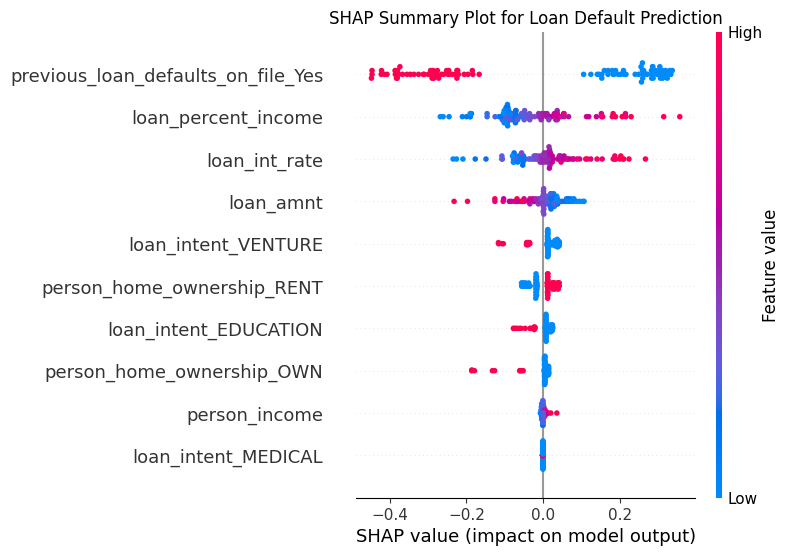


SHAP Feature Importance (Bar Plot) for Loan Data:


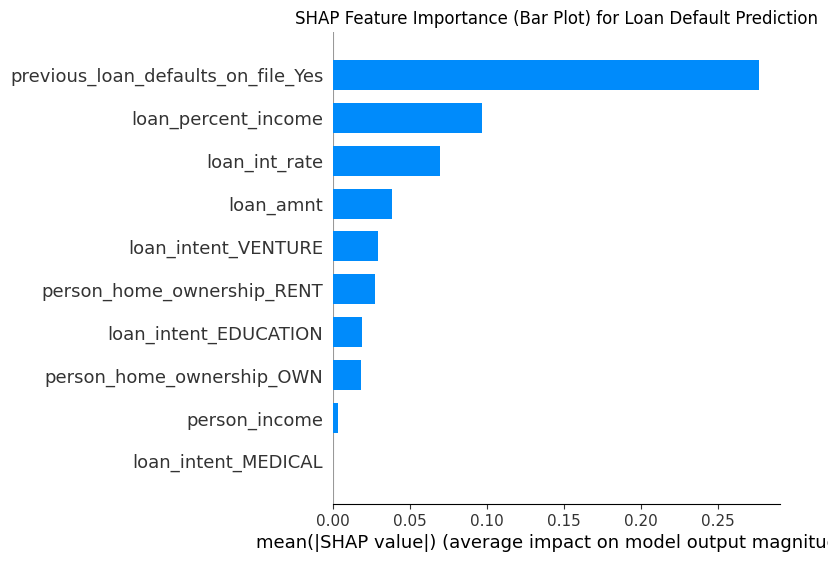


SHAP Dependence Plot for Most Important Feature (Loan Data):


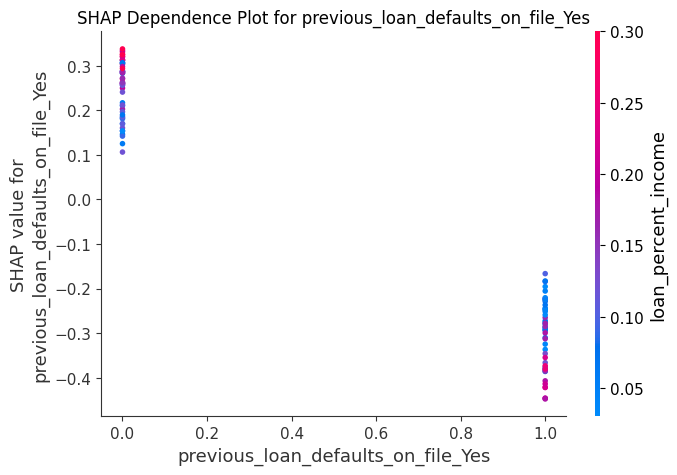

In [22]:
import shap
import matplotlib.pyplot as plt
import warnings

# Ensure the best_pipeline_loan is available from the previous step
if 'best_pipeline_loan' in locals():
    # The StandardScaler within the pipeline was originally fitted with a DataFrame.
    # To prevent 'X does not have valid feature names' warnings from SHAP,
    # refit the pipeline's StandardScaler to expect NumPy arrays.
    best_pipeline_loan.fit(X_train_loan_selected.values, y_train_loan)

    # For SHAP, we need to use the model's predict_proba
    # Create a wrapper function that returns probabilities for the positive class
    def model_predict_proba_loan(X):
        # X coming from SHAP's KernelExplainer will be a NumPy array,
        # which is now compatible with the refitted pipeline.
        return best_pipeline_loan.predict_proba(X)[:, 1]

    # Initialize KernelExplainer with the custom predict_proba function and background data
    # Ensure background_data for KernelExplainer is a NumPy array for consistency.
    background_data_loan = shap.utils.sample(X_train_loan_selected, 100, random_state=RANDOM_STATE).values

    explainer_loan = shap.KernelExplainer(model_predict_proba_loan, background_data_loan)

    # Compute SHAP values on a sample of X_test_loan_selected for interpretation
    # Keep X_sample_loan_for_shap as a DataFrame for clearer plotting with feature names.
    X_sample_loan_for_shap = shap.utils.sample(X_test_loan_selected, 100, random_state=RANDOM_STATE)
    # Pass the NumPy values to explainer.shap_values, as the explainer expects this format internally.
    shap_values_loan = explainer_loan.shap_values(X_sample_loan_for_shap.values)

    # Print shape information for debugging
    print(f"X_sample_loan shape: {X_sample_loan_for_shap.shape}")
    print(f"SHAP values loan shape: {np.array(shap_values_loan).shape}")
    print(f"Number of features used for modeling: {len(selected_features_for_modeling)}")

    # SHAP Summary Plot (Beeswarm)
    print("\nSHAP Summary Plot for Loan Data:")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        # Use the DataFrame for plotting to correctly display feature names.
        shap.summary_plot(shap_values_loan, X_sample_loan_for_shap, feature_names=selected_features_for_modeling, show=False)
        plt.title('SHAP Summary Plot for Loan Default Prediction')
        plt.show()

    # SHAP Bar Plot
    print("\nSHAP Feature Importance (Bar Plot) for Loan Data:")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        # Use the DataFrame for plotting to correctly display feature names.
        shap.summary_plot(shap_values_loan, X_sample_loan_for_shap, feature_names=selected_features_for_modeling, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (Bar Plot) for Loan Default Prediction')
        plt.show()

    # SHAP Dependence Plot for Most Important Feature
    print("\nSHAP Dependence Plot for Most Important Feature (Loan Data):")
    shap_values_loan_arr = np.array(shap_values_loan)
    # Find the index of the feature with the largest mean absolute SHAP value
    most_important_idx_loan = np.argmax(np.abs(shap_values_loan_arr).mean(axis=0))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        # Use the DataFrame for plotting to correctly display feature names.
        shap.dependence_plot(most_important_idx_loan, shap_values_loan_arr, X_sample_loan_for_shap,
                            feature_names=selected_features_for_modeling, show=False)
        plt.title(f'SHAP Dependence Plot for {selected_features_for_modeling[most_important_idx_loan]}')
        plt.show()
else:
    print("No best pipeline available for SHAP analysis. Ensure Optuna optimization ran successfully.")

คะแนน F1 score ที่ 0.7334 ได้มาจากการใช้โมเดล Logistic Regression ที่ผ่านการปรับจูนไฮเปอร์พารามิเตอร์ด้วย Optuna โดยใช้ฟีเจอร์ที่ถูกเลือกจากการลงคะแนนเสียงส่วนใหญ่จาก 3 วิธีการเลือกฟีเจอร์ ดังนี้ครับ



**1. การแปลงข้อมูล (Transformation): **ฟีเจอร์ที่เป็นหมวดหมู่ (categorical features) ถูกแปลงเป็นตัวเลขโดยใช้เทคนิค One-Hot Encoding (pd.get_dummies) ซึ่งสร้างคอลัมน์ใหม่ที่เป็นเลขฐานสอง (0 หรือ 1) สำหรับแต่ละหมวดหมู่ของฟีเจอร์เดิม

**2. การเลือกฟีเจอร์ (Feature Selection): **มีการใช้ 3 วิธีหลัก และเลือกฟีเจอร์ที่ได้รับคะแนนเสียงส่วนใหญ่ (อย่างน้อย 2 ใน 3 วิธี) ได้แก่:

Correlation-Based Feature Selection: เลือกฟีเจอร์ที่มีความสัมพันธ์ (correlation) กับ loan_status สูงกว่าค่าที่กำหนด
SelectKBest with f_classif: เลือก k อันดับแรกของฟีเจอร์ที่มี F-score สูงสุด ซึ่งบ่งชี้ถึงความสัมพันธ์ทางสถิติกับตัวแปรเป้าหมาย
SelectFromModel with L1-based Logistic Regression: เลือกฟีเจอร์ที่มีสัมประสิทธิ์ (coefficients) ไม่เป็นศูนย์จากโมเดล Logistic Regression ที่ใช้ L1 regularization ซึ่งช่วยในการเลือกฟีเจอร์โดยธรรมชาติ
จากสามวิธีนี้ 10 ฟีเจอร์ ได้รับการคัดเลือกด้วยการลงคะแนนเสียงส่วนใหญ่ (majority vote) สำหรับการสร้างโมเดล ซึ่งประกอบด้วย: 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_MEDICAL', 'loan_intent_VENTURE', และ 'previous_loan_defaults_on_file_Yes'

โมเดลถูกฝึกด้วยฟีเจอร์ที่ถูกเลือกเหล่านี้ และผลการประเมินบนชุดข้อมูลทดสอบ